In [156]:
import numpy as np
import matplotlib.pyplot as plt

In [157]:
suspicious_peaks = np.load(r"C:\Users\victo\VSCode Folder\mass_spec_project\data\suspicious_peaks\suspicious_peaks.npz", allow_pickle=True)
grids = suspicious_peaks["grids"]
mz_axes = suspicious_peaks["mz_axes"]
rt_axes = suspicious_peaks["rt_axes"]
ds_rt = suspicious_peaks["d_rt"]
dds_rt = suspicious_peaks["dd_rt"]
zones = suspicious_peaks["zones"]

In [158]:
print("Grid shape:", grids[0].shape)
print("m/z axis length:", len(mz_axes[0]))
print("RT axis length:", len(rt_axes[0]))




Grid shape: (44, 40)
m/z axis length: 44
RT axis length: 40


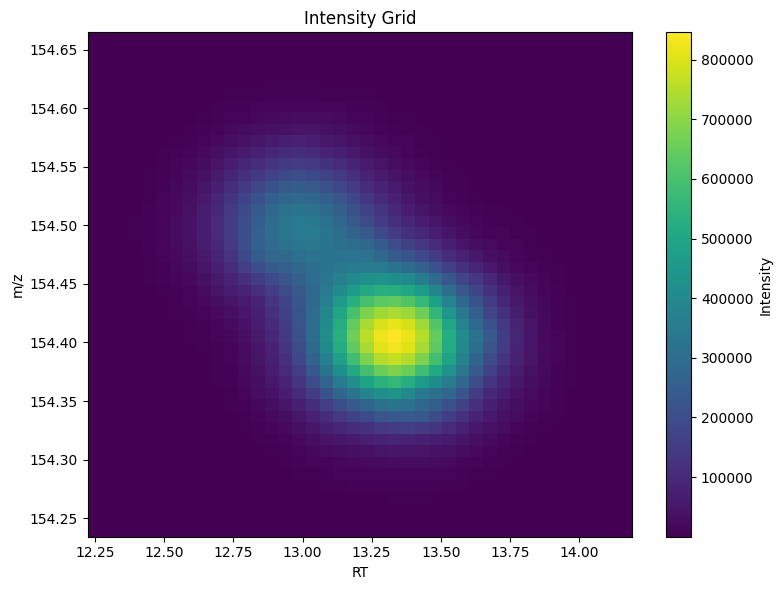

In [159]:
def plot_grid(grid, mz_axis, rt_axis, title="Intensity Grid"):
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title(title)
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')
    plt.tight_layout()
    plt.show()

plot_grid(np.array(grids[0], dtype=float), mz_axes[0], rt_axes[0])

In [160]:
MIN_INTENSITY = 3e4
MIN_SLOPE = 0.1     # threshold for considering a ridge direction valid
FORK_SEP = 2        # minimum RT steps between branches to declare fork
FORK_WIDTH = 3      # minimum m/z width between forks

In [161]:
def find_local_maxima(column, threshold):
    """
    Find m/z indices in a column that are local maxima and exceed the threshold.
    """
    maxima = []
    for i in range(1, len(column) - 1):
        if column[i] > threshold and column[i] > column[i - 1] and column[i] > column[i + 1]:
            maxima.append(i)
    return maxima

In [162]:
def extend_ridge_one_direction(start_mz, start_rt, grid, d_rt, direction, min_intensity, min_slope):
    """
    Extend a ridge forward or backward in RT from a seed point.
    direction: +1 for forward, -1 for backward
    """
    path = []
    mz_len, rt_len = grid.shape
    current_mz, current_rt = start_mz, start_rt

    while 0 <= current_rt + direction < rt_len:
        next_rt = current_rt + direction
        mz_window = range(max(0, current_mz - 1), min(mz_len, current_mz + 2))
        candidates = []
        for mz in mz_window:
            intensity = grid[mz, next_rt]
            slope_idx = next_rt if direction == -1 else next_rt - 1
            slope = d_rt[mz, slope_idx] if 0 <= slope_idx < d_rt.shape[1] else 0

            if direction == 1 and slope >= min_slope and intensity >= min_intensity:
                candidates.append((mz, intensity))
            elif direction == -1 and slope <= -min_slope and intensity >= min_intensity:
                candidates.append((mz, intensity))

        if not candidates:
            break
        current_mz, _ = max(candidates, key=lambda x: x[1])
        current_rt = next_rt
        path.append((current_mz, current_rt))

    return path

def track_single_ridge_bidirectional(mz_idx, rt_idx, grid, d_rt, min_intensity, min_slope):
    """
    Track a ridge in both forward and backward RT directions from a starting point.
    """
    backward_path = extend_ridge_one_direction(mz_idx, rt_idx, grid, d_rt, -1, min_intensity, min_slope)
    forward_path = extend_ridge_one_direction(mz_idx, rt_idx, grid, d_rt, 1, min_intensity, min_slope)
    return backward_path[::-1] + [(mz_idx, rt_idx)] + forward_path

In [163]:
def track_all_ridges(grid, d_rt, min_intensity=3e4, min_slope=0.1):
    """
    Scan across RT to find and track all ridge paths.
    """
    ridge_paths = []
    visited = np.zeros_like(grid, dtype=bool)  # Prevent duplicate tracking

    mz_len, rt_len = grid.shape

    for rt_idx in range(rt_len):
        column = grid[:, rt_idx]
        local_maxima = find_local_maxima(column, min_intensity)

        for mz_idx in local_maxima:
            if visited[mz_idx, rt_idx]:
                continue

            path = track_single_ridge_bidirectional(mz_idx, rt_idx, grid, d_rt, min_intensity, min_slope)
            # print(f"Trying seed at RT={rt_idx}, m/z={mz_idx}")

            if len(path) > 1:
                ridge_paths.append(path)
                for mz, rt in path:
                    visited[mz, rt] = True  # Mark as visited
    print("Paths:", ridge_paths)
    return ridge_paths



In [164]:
def plot_ridges_on_grid(grid, mz_axis, rt_axis, ridges):
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title("Ridge Overlay")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')

    for ridge in ridges:
        mz_indices, rt_indices = zip(*ridge)
        mz_values = mz_axis[list(mz_indices)]
        rt_values = rt_axis[list(rt_indices)]
        plt.plot(rt_values, mz_values, color='red', linewidth=1)

    plt.show()

In [165]:
def compute_valley_score_between_ridges(grid, ridge1, ridge2):
    """
    For two ridge paths, compute the intensity valley score between them.

    Parameters:
        grid (2D np.array): Intensity grid (m/z × RT)
        ridge1 (list of (mz_idx, rt_idx)): First ridge path
        ridge2 (list of (mz_idx, rt_idx)): Second ridge path

    Returns:
        dict with 'overlap_rt', 'valley_intensity', 'ridge1_max', 'ridge2_max', 'score'
    """
    ridge1_dict = {rt: mz for mz, rt in ridge1}
    ridge2_dict = {rt: mz for mz, rt in ridge2}

    common_rts = sorted(set(ridge1_dict.keys()) & set(ridge2_dict.keys()))
    if len(common_rts) < 3:
        return None  # Not enough overlap to compute a valley

    valley_intensities = []
    ridge1_intensities = []
    ridge2_intensities = []

    for rt in common_rts:
        mz1 = ridge1_dict[rt]
        mz2 = ridge2_dict[rt]
        if mz1 == mz2:
            continue
        mz_min, mz_max = sorted([mz1, mz2])
        valley_line = grid[mz_min+1:mz_max, rt] if mz_max - mz_min > 1 else []
        if len(valley_line) > 0:
            valley_intensities.append(np.min(valley_line))
        ridge1_intensities.append(grid[mz1, rt])
        ridge2_intensities.append(grid[mz2, rt])

    if not valley_intensities:
        return None

    valley = np.median(valley_intensities)
    ridge1_max = np.max(ridge1_intensities)
    ridge2_max = np.max(ridge2_intensities)
    score = min(ridge1_max, ridge2_max) - valley
    norm_score = score / max(ridge1_max, ridge2_max)
    asymmetry = abs(ridge1_max - ridge2_max) / (ridge1_max + ridge2_max + 1e-9)
    confidence = norm_score * (1 - asymmetry)
    
    return {
        "overlap_rt": common_rts,
        "ridge1_max": ridge1_max,
        "ridge2_max": ridge2_max,
        "valley_intensity": valley,
        "score": score,
        "norm_score": norm_score,
        "asymmetry": asymmetry,
        "split_confidence": confidence
    }


In [166]:
def compute_ridge_widths(grid, ridge):
    widths = []
    for mz_idx, rt_idx in ridge:
        intensity = grid[mz_idx, rt_idx]
        half_max = intensity / 2
        # Search left
        left = mz_idx
        while left > 0 and grid[left, rt_idx] > half_max:
            left -= 1
        # Search right
        right = mz_idx
        while right < grid.shape[0] - 1 and grid[right, rt_idx] > half_max:
            right += 1
        width = right - left
        widths.append(width)
    return np.median(widths)


In [167]:
def compute_intensity_smoothness(grid, ridge):
    intensities = [grid[mz_idx, rt_idx] for mz_idx, rt_idx in ridge]
    derivatives = np.diff(intensities)
    smoothness = np.std(derivatives)
    return smoothness


In [169]:
def compute_fork_sharpness(dd_rt, ridge1, ridge2):
    overlap_rts = set(rt for _, rt in ridge1) & set(rt for _, rt in ridge2)
    sharpness_values = []
    for rt in overlap_rts:
        mz1 = next(mz for mz, r in ridge1 if r == rt)
        mz2 = next(mz for mz, r in ridge2 if r == rt)
        dd1 = dd_rt[mz1, rt] if 0 <= mz1 < dd_rt.shape[0] and 0 <= rt < dd_rt.shape[1] else 0
        dd2 = dd_rt[mz2, rt] if 0 <= mz2 < dd_rt.shape[0] and 0 <= rt < dd_rt.shape[1] else 0
        sharpness = abs(dd1 - dd2)
        sharpness_values.append(sharpness)
    return np.mean(sharpness_values) if sharpness_values else 0


In [168]:
def compute_fusion_score(width_diff, smoothness_diff, fork_sharpness, weights):
    # Normalize metrics
    width_score = 1 - np.tanh(width_diff)
    smoothness_score = 1 - np.tanh(smoothness_diff)
    fork_score = np.tanh(fork_sharpness)
    # Weighted sum
    fusion_score = (weights['width'] * width_score +
                    weights['smoothness'] * smoothness_score +
                    weights['fork'] * fork_score)
    return fusion_score


Paths: [[(27, 7), (27, 8), (27, 9), (27, 10), (26, 11), (25, 12), (26, 13), (26, 14), (26, 15), (25, 16), (24, 17), (23, 18), (22, 19), (21, 20), (20, 21), (19, 22)], [(18, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22)], [(26, 15), (26, 16)], [(26, 15), (26, 16), (25, 17)], [(17, 22), (17, 23)], [(17, 22), (17, 23), (17, 24)], [(17, 22), (17, 23), (17, 24), (17, 25)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31)], [(17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (16, 32)]]
Evaluating ridge splits based on vall

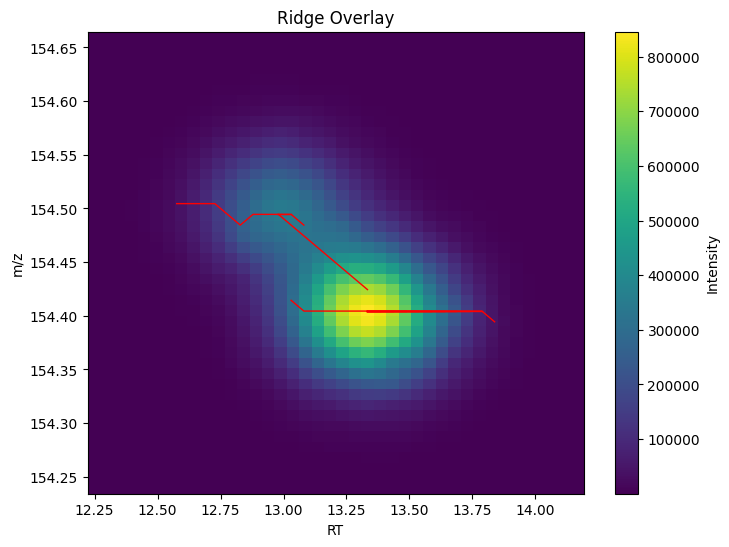

In [173]:
grid_labels = []

for idx in range(len(grids)):
    grid = np.array(grids[idx], dtype=float)
    mz_axis = mz_axes[idx]
    rt_axis = rt_axes[idx]
    d_rt = np.array(ds_rt[idx], dtype=float)
    dd_rt = np.array(dds_rt[idx], dtype=float)

    # Track ridges
    ridges = track_all_ridges(grid, d_rt, min_intensity=3e4, min_slope=1e2)
    print("Evaluating ridge splits based on valleys...")

    weights = {"width": 0.3, "smoothness": 0.3, "fork": 0.4}

    for i in range(len(ridges)):
        for j in range(i + 1, len(ridges)):
            ridge1 = ridges[i]
            ridge2 = ridges[j]
            result = compute_valley_score_between_ridges(grid, ridge1, ridge2)

            if result is not None:
                width1 = compute_ridge_widths(grid, ridge1)
                width2 = compute_ridge_widths(grid, ridge2)
                width_diff = abs(width1 - width2)

                smooth1 = compute_intensity_smoothness(grid, ridge1)
                smooth2 = compute_intensity_smoothness(grid, ridge2)
                smoothness_diff = abs(smooth1 - smooth2)

                fork_sharpness = compute_fork_sharpness(dd_rt, ridge1, ridge2)

                fusion_score = compute_fusion_score(width_diff, smoothness_diff, fork_sharpness, weights)

                print(f"Ridge Pair {i}-{j}:")
                print(f"  Widths: {width1:.2f} vs {width2:.2f} → Δ = {width_diff:.2f}")
                print(f"  Smoothness: {smooth1:.2f} vs {smooth2:.2f} → Δ = {smoothness_diff:.2f}")
                print(f"  Fork Sharpness: {fork_sharpness:.2f}")
                print(f"  Fusion Score: {fusion_score:.3f}")
                label = "overlap" if fusion_score >= 0.5 else "single"
                grid_labels.append(label)



    # Plot the ridges on the grid
    plot_ridges_on_grid(grid, mz_axis, rt_axis, ridges)

In [174]:
print(grid_labels)

['overlap']
